<a href="https://colab.research.google.com/github/OmarShafie/DeepLearning-HBKU/blob/master/bio_segments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Dec 22 19:35:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers
!pip install farasapy
!pip install pyarabic
!pip install python-bidi
!pip install arabic_reshaper
!git clone https://github.com/aub-mind/arabert 
!pip install ktrain
!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

     |████████████████████████████████| 1.5MB 9.2MB/s 
     |████████████████████████████████| 890kB 28.5MB/s 
     |████████████████████████████████| 2.9MB 43.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=eed66d3b359b5dc4f1a68c8ef2db1281e8b0b950ed0572288c857d3057e5f226
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 112kB 8.2MB/s 
  Created wheel for pyarabic: filename=PyArabic-0.6.10-cp36-none-any.whl size=113324 sha256=8ec4430953c4315181747d6913943d20871be1ab3104847ef63b580d0ec54187
  Stored in directory: /root/.cache/pip/wheels/10/b8/f5/b7c1a50e6efb83544844f165a9b134afe7292585465e29b61d
Successfully built pyarabic
  Created wheel for arabic-reshaper: filename=arabic_reshaper-2.1.1-cp36-none-any.whl size=16504 sha256=b6dd8e18b708617c0e09a9951fee03ad45f6d15468f6f7b33f0f30ca9a7ff7a0
  Stored in directo

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
dataset_directory = 'gdrive/MyDrive/HBKU/Research/datasets/tutorial/'
!ls '$dataset_directory'

'data - data.csv'     rawi_bio_category.csv    spidyquotes-viewstate.py
 narrators.csv	      rawi_bio.csv	       takhreeg.csv
 narrators-utf8.csv   rawi_bio_grade.csv       takhreeg.numbers
 quotes-1.html	      rawi_bio_grade_old.csv   tutorial
 quotes-2.html	      README.md
 quotes.json	      scrapy.cfg


In [5]:
import pandas as pd
import numpy as np

from farasa.segmenter import FarasaSegmenter
from arabert.preprocess_arabert import preprocess, never_split_tokens

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
import sklearn.feature_extraction

from transformers import AutoConfig, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments

#viz
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper
from bs4 import BeautifulSoup

import matplotlib.gridspec as gridspec 
import seaborn as sns

import ktrain
from ktrain import text

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

farasa_segmenter = FarasaSegmenter(interactive=True)

 99%|█████████▉| 239M/241M [00:13<00:00, 18.4MiB/s]

[2020-12-22 19:37:45,183 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [6]:
path_bio_category = dataset_directory + '/rawi_bio_category.csv'
df_bio_category = pd.read_csv(path_bio_category, header=0)

df_bio_category.head()

,rawi_index,faeeda_id,faeeda_source,faeeda_category,faeeda_text
0,3,48003065.0,441140,إثبات سماع الراوي,<span>قال محمد بن سعد : كان من أبناء أهل خراسا...
1,3,49003698.0,464601,إثبات سماع الراوي,<span>وقال ابن سعد : سمع من شعبة سماعا كثيرا</...
2,3,520035218.0,531969,إثبات سماع الراوي,<span>وقال ابن سعد في « الطبقات الكبير » : سمع...
3,4,490037010.0,464603,الإرسال,<span>ولم يدركه ابنه</span>
4,4,50002602.0,490291,إثبات سماع الراوي,<span>سمع سعيد بن جبير</span>


In [7]:
#fill empty cells
#same text, multi label
print("Check for missing values in Train dataset")
null_check=df_bio_category.isnull().sum()
print(null_check)
#print("filling NA with \"unknown\"")
#df_bio_category["faeeda_category"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
rawi_index          0
faeeda_id          21
faeeda_source       8
faeeda_category     0
faeeda_text         0
dtype: int64


In [8]:
#split to test and train
#split train to k folds fro validation
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

df_bio_category = df_bio_category[['faeeda_text', 'faeeda_category']]
df_bio_category.columns = [DATA_COLUMN, LABEL_COLUMN]

df_bio_category.drop_duplicates(subset=None, keep="first", inplace=True)
df_bio_category[DATA_COLUMN] = df_bio_category[DATA_COLUMN].apply(lambda x: preprocess(BeautifulSoup(x, "lxml").text, do_farasa_tokenization=True , farasa=farasa_segmenter, use_farasapy = True))
X_train, X_test = train_test_split(df_bio_category, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)

100%|██████████| 241M/241M [00:30<00:00, 18.4MiB/s](12026, 2)
(3007, 2)


Max of train len:  703
Max of test len:  1385


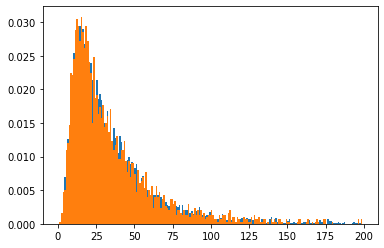

In [9]:
train_sentence_length = [ len(text.split()) for text in X_train['text'] ]
test_sentence_length = [ len(text.split()) for text in X_test['text'] ]

print("Max of train len: ",np.max(train_sentence_length))
print("Max of test len: ",np.max(test_sentence_length))

plt.hist(train_sentence_length,bins= range(200),density=True)
plt.hist(test_sentence_length,bins= range(200),density=True)
plt.show()

In [10]:
cats = df_bio_category['label'].value_counts()
class_names = list(cats.index)

In [11]:
print(',\n'.join(class_names))

الإرسال,
المفاضلة بين الرواة,
إثبات سماع الراوي,
الإدراك,
التوثيق الضمني,
الاختلاط,
التدليس,
الاختلاف في سماع الراوي,
المفاضلة بين الرواة في راو,
التضعيف الاستثنائي,
التوثيق الاستثنائي,
التضعيف الضمني,
المفاضلة بين الرواة في بلد


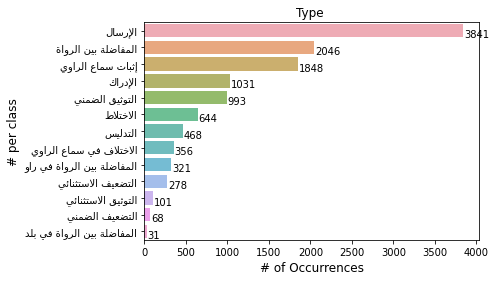

In [12]:
plt.figure()

count = list(X_train['label'].value_counts())

reshaped_categories = [get_display(arabic_reshaper.reshape(cat)) for cat in class_names]
ax= sns.barplot(y=reshaped_categories, x=count, alpha=0.8)
plt.title('Type ')
plt.ylabel("# per class", fontsize=12)
plt.xlabel('# of Occurrences', fontsize=12)
#adding the text labels
rects = ax.patches
for rect, label in zip(rects, count):
    ax.text(rect.get_x() + rect.get_width() + 10,  rect.get_y() + rect.get_height(), label)

plt.show()

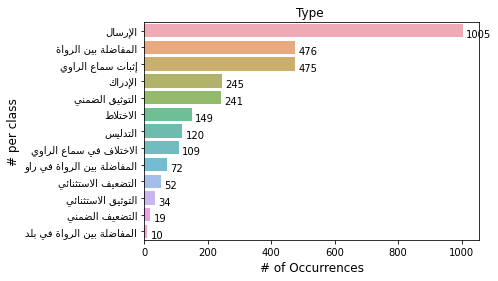

In [13]:
plt.figure()

count = list(X_test['label'].value_counts())

reshaped_categories = [get_display(arabic_reshaper.reshape(cat)) for cat in class_names]
ax= sns.barplot(y=reshaped_categories, x=count, alpha=0.8)
plt.title('Type ')
plt.ylabel("# per class", fontsize=12)
plt.xlabel('# of Occurrences', fontsize=12)
#adding the text labels
rects = ax.patches
for rect, label in zip(rects, count):
    ax.text(rect.get_x() + rect.get_width() + 10,  rect.get_y() + rect.get_height(), label)

plt.show()

In [16]:
MODEL_NAME = 'aubmindlab/bert-base-arabert'
arabert_t = text.Transformer(MODEL_NAME, maxlen=300)
trn = arabert_t.preprocess_train(X_train['text'].values, X_train['label'].values)
val = arabert_t.preprocess_test(X_test['text'].values, X_test['label'].values)
arabert_model = arabert_t.get_classifier()
arabert_learner = ktrain.get_learner(arabert_model, train_data=trn, val_data=val, batch_size=16)

preprocessing train...
language: ar
train sequence lengths:
	mean : 37
	95percentile : 96
	99percentile : 177


Is Multi-Label? False
preprocessing test...
language: ar
test sequence lengths:
	mean : 37
	95percentile : 99
	99percentile : 169


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
751/751 [==============================] - 795s 1s/step - loss: 2.5468 - accuracy: 0.1170
Epoch 2/5
751/751 [==============================] - 789s 1s/step - loss: 1.0816 - accuracy: 0.7133
Epoch 3/5
751/751 [==============================] - 787s 1s/step - loss: 1.9784 - accuracy: 0.3533
Epoch 4/5
751/751 [==============================] - 346s 460ms/step - loss: 4.7580 - accuracy: 0.2450


done.
Visually inspect loss plot and select learning rate associated with falling loss


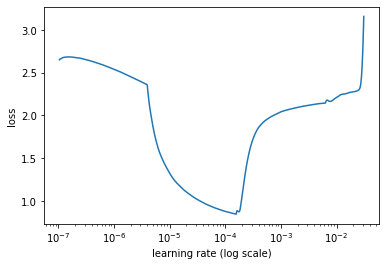

In [17]:
arabert_learner.lr_find(max_epochs=5)

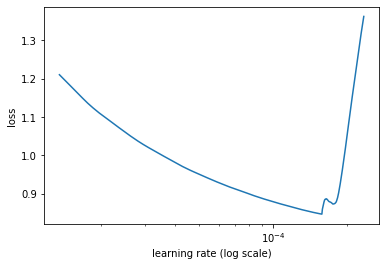

In [33]:
arabert_learner.lr_plot(n_skip_beginning=1000, n_skip_end= 1000)

In [34]:
LEARNING_RATE = 1e-4
EPOCHS = 5

In [35]:
arabert_learner.fit_onecycle(LEARNING_RATE, EPOCHS)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/5
752/752 [==============================] - 865s 1s/step - loss: 1.3459 - accuracy: 0.5930 - val_loss: 0.5321 - val_accuracy: 0.8384
Epoch 2/5
752/752 [==============================] - 857s 1s/step - loss: 0.4528 - accuracy: 0.8639 - val_loss: 0.5598 - val_accuracy: 0.8237
Epoch 3/5
752/752 [==============================] - 856s 1s/step - loss: 0.4138 - accuracy: 0.8688 - val_loss: 0.4465 - val_accuracy: 0.8510
Epoch 4/5
752/752 [==============================] - 857s 1s/step - loss: 0.3112 - accuracy: 0.8921 - val_loss: 0.4350 - val_accuracy: 0.8523
Epoch 5/5
752/752 [==============================] - 858s 1s/step - loss: 0.1893 - accuracy: 0.9269 - val_loss: 0.4224 - val_accuracy: 0.8646


In [36]:
arabert_model = ktrain.get_predictor(arabert_learner.model, arabert_t)

In [37]:
# save model for later use
arabert_model.save('gdrive/MyDrive/HBKU/Research/models/bio_segments_classification/arabic_predictor_2')

In [14]:
# reload from disk
arabert_model = ktrain.load_predictor('gdrive/MyDrive/HBKU/Research/models/bio_segments_classification/arabic_predictor_2')

In [15]:
scores = {}

pred = arabert_model.predict(X_test["text"].values)
scores['arabert'] = sklearn.metrics.f1_score(X_test["label"], pred, average='weighted')
scores['arabert']

INFO:filelock:Lock 139852458926032 acquired on /root/.cache/torch/transformers/5f2666e4ad33500fda9a2580bce4bfba25f18637610f95fd6f013057862055c0.707ab683c74596195bd2157e0a1bb00509b1eb07501dfc4f4d9ae1dca1e2882e.lock


INFO:filelock:Lock 139852458926032 released on /root/.cache/torch/transformers/5f2666e4ad33500fda9a2580bce4bfba25f18637610f95fd6f013057862055c0.707ab683c74596195bd2157e0a1bb00509b1eb07501dfc4f4d9ae1dca1e2882e.lock


INFO:filelock:Lock 139852459038704 acquired on /root/.cache/torch/transformers/bbe9f2b9dd977bb35e3d92d8a1497459845e8800edc1932aab39b016542c5f1a.9fbad0a2ff48615b5d937c288c24e868d60b6d152899ce1a9faf885dd137ebf0.lock


INFO:filelock:Lock 139852459038704 released on /root/.cache/torch/transformers/bbe9f2b9dd977bb35e3d92d8a1497459845e8800edc1932aab39b016542c5f1a.9fbad0a2ff48615b5d937c288c24e868d60b6d152899ce1a9faf885dd137ebf0.lock


INFO:filelock:Lock 139852459038592 acquired on /root/.cache/torch/transformers/b14bafdd3d95b4cd9c4ce4958e3e6488c96e8e1f25685293f0cb86331e0b6c84.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


INFO:filelock:Lock 139852459038592 released on /root/.cache/torch/transformers/b14bafdd3d95b4cd9c4ce4958e3e6488c96e8e1f25685293f0cb86331e0b6c84.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


INFO:filelock:Lock 139852458553584 acquired on /root/.cache/torch/transformers/701713c56f0708fc598112a1d7974de4939f65bfebd60b5f50a00a99476a4806.04a369923a9a8c897af9c7e64fcb9203fe32e862c546bfe86749cd0d3460ea58.lock


INFO:filelock:Lock 139852458553584 released on /root/.cache/torch/transformers/701713c56f0708fc598112a1d7974de4939f65bfebd60b5f50a00a99476a4806.04a369923a9a8c897af9c7e64fcb9203fe32e862c546bfe86749cd0d3460ea58.lock


INFO:filelock:Lock 139852459039992 acquired on /root/.cache/torch/transformers/50e8cbeae7b4a85c95f7705a9ac1f69b4e40a7c2aedd94bc5edf7e5119f16792.5f74e6571792ef686d35a55ccacc3bbd11c0333406b53a1290db15e6f7793a9a.lock


INFO:filelock:Lock 139852459039992 released on /root/.cache/torch/transformers/50e8cbeae7b4a85c95f7705a9ac1f69b4e40a7c2aedd94bc5edf7e5119f16792.5f74e6571792ef686d35a55ccacc3bbd11c0333406b53a1290db15e6f7793a9a.lock


0.8619847158481074

In [16]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

classifiers = {
    'mnb' : MultinomialNB(alpha=.01),
    'knn' : KNeighborsClassifier(15),
    'svm' : SVC(kernel="linear", C=0.025),
    'rbf' : SVC(gamma=2, C=1),
    'dtc' : DecisionTreeClassifier(max_depth=9),
    'rfc' : RandomForestClassifier(max_depth=5, n_estimators=20, max_features=12),
    'mlp' : MLPClassifier(alpha=1, max_iter=1000),
    'ada' : AdaBoostClassifier(),
    }

In [17]:
import sklearn.feature_extraction
#ToDo: try other vectorizers
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(X_train["text"])
test_vectors = vectorizer.transform(X_test["text"])

In [18]:
from sklearn.pipeline import make_pipeline

for cls in classifiers:
  model = classifiers[cls]
  model.fit(train_vectors, X_train["label"])
  classifiers[cls] = make_pipeline(vectorizer, model)
  pred = model.predict(test_vectors)
  scores[cls] = sklearn.metrics.f1_score(X_test["label"], pred, average='weighted')
  print(cls, scores[cls])

mnb 0.7210956124719479
knn 0.7368453615196618
svm 0.5639348229159277
rbf 0.7836525058411312
dtc 0.5904286256094471
rfc 0.168148763364162
mlp 0.7158563669912464
ada 0.6554048640552185


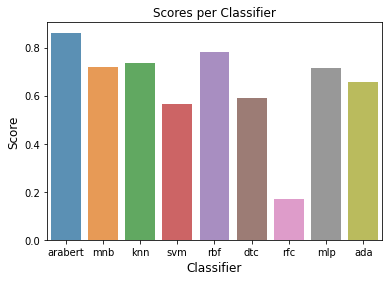

In [19]:
plt.figure()

ax= sns.barplot(y=list(scores.values()), x=list(scores.keys()), alpha=0.8)
plt.title('Scores per Classifier')
plt.ylabel("Score", fontsize=12)
plt.xlabel('Classifier', fontsize=12)
#adding the text labels
rects = ax.patches
plt.show()

In [20]:
arabert_learner.view_top_losses(n=1, preproc=arabert_t)

NameError: ignored

To Try:
* Use Qarib (QCRI BERT)
* Fine Tuning Hyper parameters
* Freeze and retrain
* ktrain modify model

To Answer:
* Number of training examples vs Accuracy of the model?
* Sequence Tag to biographic texts
* build CA BERT